Fitting 3 folds for each of 81 candidates, totalling 243 fits


C:\Users\kl0636\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'activation': 'leaky_relu', 'batch_size': 32, 'epochs': 200, 'optimizer': 'rmsprop'}
Best Score: -241.11867577587645
Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 91896.9375 - mae: 297.5262 - val_loss: 49069.2617 - val_mae: 216.9469
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51883.5469 - mae: 203.1188 - val_loss: 52482.8750 - val_mae: 227.8979
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43650.4727 - mae: 182.2697 - val_loss: 38285.7539 - val_mae: 194.9955
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30557.4492 - mae: 151.3045 - val_loss: 14763.8623 - val_mae: 120.6743
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22788.5273 - mae: 127.4811 - val_loss: 11289.6904 - val_mae: 105.3399
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20272.7129 - mae: 116.7779 - val_loss: 15210.6719 - val_mae: 122.5587
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18582.6582 - mae: 115.0759 - val

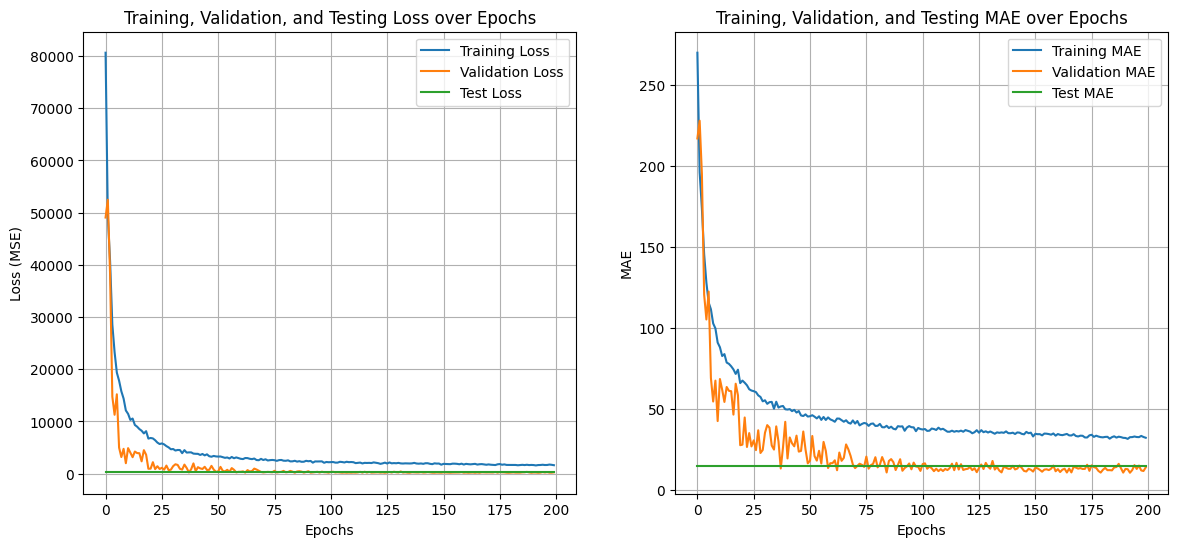

In [21]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, normalize
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Load .mat file
mat = scipy.io.loadmat('data_GaN_8_15micron_1.mat')

# Extract and reshape data
Temp_all = mat.get('T_GaN_random')
temp_line = Temp_all.reshape(2000, 50)

Spectra_all = mat.get('Spectrum')
spectra_line = Spectra_all.reshape(2000, 355)

# Create pandas DataFrame
pd_spectra = pd.DataFrame(spectra_line)
pd_temp = pd.DataFrame(temp_line)

# Select the data
X = pd_spectra.iloc[0:2000]
Y = pd_temp.iloc[0:2000]

# Scale the features using RobustScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Create polynomial features
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X_scaled)

# # Apply PCA for dimensionality reduction
# pca = PCA(n_components=50)  # Adjust n_components based on variance explained
# X_pca = pca.fit_transform(X_poly)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1337)

X_train_normal = normalize(X_train)
X_val_normal = normalize(X_val)
X_test_normal = normalize(X_test)

# Create model function
def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for _ in range(30): 
        model.add(Dense(30))
        if activation == 'leaky_relu':
            model.add(LeakyReLU(negative_slope=0.1))
        else:
            model.add(tf.keras.layers.Activation(activation))
        # model.add(BatchNormalization())
        model.add(Dropout(0.2))
    model.add(Dense(50))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Define KerasRegressor
model = KerasRegressor(model=create_model, activation='relu', batch_size=32, epochs=100, verbose=0)

# Define parameter grid
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
                #   , 'adamw', 'adadelta', 'adagrad', 'adamax', 'nadam'],
    'activation': ['relu', 'tanh','leaky_relu'],
                #    'elu', 'sigmoid']
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 200]}

# Use GridSearchCV to find the best combination of hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_normal, y_train)

# Display the best hyperparameters and corresponding score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

# Train the model with the best hyperparameters
best_params = grid_result.best_params_
best_model = create_model(optimizer=best_params['optimizer'], activation=best_params['activation'])

history = best_model.fit(X_train_normal, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val_normal, y_val), verbose=1)

# Save the model
# best_model.save('improved_temperature_prediction_model_v2.keras')

# Print training metrics
print(f"train_MSE: {history.history['loss'][-1]}")
print(f"train_MAE: {history.history['mae'][-1]}")

# Evaluate the model on the validation set
validation_loss, validation_mae = best_model.evaluate(X_val_normal, y_val)
print(f"val_MSE: {validation_loss}, val_MAE: {validation_mae}")

# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"test_MSE: {test_loss}, test_MAE: {test_mae}")

# Add test metrics to the history for plotting
history.history['test_loss'] = [test_loss] * len(history.history['loss'])
history.history['test_mae'] = [test_mae] * len(history.history['mae'])

# Plot training & validation loss and mae values
plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label='Training Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.plot(history.history["test_loss"], label='Test Loss')
plt.title('Training, Validation, and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.plot(history.history["test_mae"], label="Test MAE")
plt.title('Training, Validation, and Testing MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.show()


# model = Sequential()
# model.add(Input(shape=(X_train_normal.shape[1],)))

# for i in range(30): 
#     model.add(Dense(30, activation="relu"))
#     model.add(Dropout(0.3))

# model.add(Dense(50))

# model.compile(optimizer="rmsprop", loss='mse', metrics=['mae'])

# history = model.fit(X_train_normal, y_train, epochs=150, batch_size=16, validation_data=(X_val_normal, y_val))